In [ ]:
import pandas as pd
import missingno as msn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link='https://drive.google.com/file/d/1XkiwCsfJi00CjwTl4EupjytO6HjIVbWf/view?usp=share_link'
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('SpotifyFeatures.csv')
main_df=pd.read_csv("SpotifyFeatures.csv")
main_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
main_df['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [ ]:
print(main_df.shape)

(232725, 18)


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [ ]:
main_df.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [ ]:
#As no rows were dropped, it implies that there are no duplicated rows in this dataframe
#Now, we know that genre won't have much significance in the clustering of songs of similar types, as we are only using certain aspects of songs
#Also, track name and artist name won't be used
main_df.pop('track_name')
main_df.pop('artist_name')
main_df=main_df.dropna()
main_df.shape

(232725, 16)

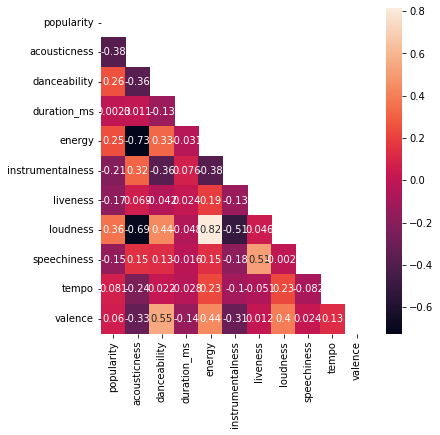

In [ ]:
#just to get a better understanding of what makes a song popular, let's make a corrplot of the system
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
mask = np.zeros_like(main_df.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(main_df.corr(), mask= mask, ax= ax, annot= True)

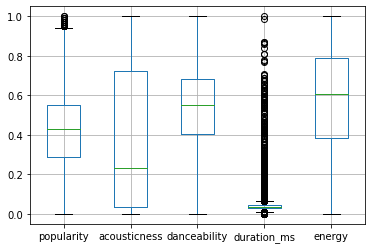

In [ ]:
cols=[col for col in main_df.columns if main_df[col].dtype!='object']
#Normalising the entire dataframe
main_df[cols]=(main_df[cols]-main_df[cols].min())/(main_df[cols].max()-main_df[cols].min())
#BoxPlots
boxp=main_df.boxplot(column=[cols[0],cols[1],cols[2],cols[3],cols[4]])

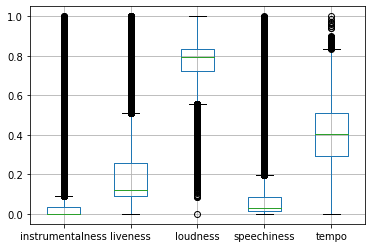

In [ ]:
boxp=main_df.boxplot(column=[cols[5],cols[6],cols[7],cols[8],cols[9]])

In [ ]:
label_encoder = preprocessing.LabelEncoder()
main_df['genre']= label_encoder.fit_transform(main_df['genre'])
main_df['mode']=label_encoder.fit_transform(main_df['mode'])
main_df['key']=label_encoder.fit_transform(main_df['key'])
main_df['time_signature']=label_encoder.fit_transform(main_df['time_signature'])
main_df

,genre,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,15,0BRjO6ga9RKCKjfDqeFgWV,0.00,0.613454,0.356292,0.015167,0.910909,0.000000,4,0.339614,0.900856,0,0.032070,0.642704,3,0.814
1,15,0BjC1NfoEOOusryehmNudP,0.01,0.246988,0.571934,0.022029,0.737732,0.000000,9,0.142710,0.834469,1,0.068374,0.675801,3,0.816
2,15,0CoSDzoNIKCRs124s9uTVy,0.03,0.955823,0.650252,0.027969,0.131113,0.000000,3,0.094241,0.686429,1,0.014818,0.325182,4,0.368
3,15,0Gc6TVm52BwZD07Ki6tIvf,0.00,0.705823,0.196438,0.024747,0.326313,0.000000,4,0.089697,0.716695,0,0.018311,0.665238,3,0.227
4,15,0IuslXpMROHdEPvSl1fTQK,0.04,0.953815,0.294067,0.012142,0.225209,0.123123,8,0.194208,0.557054,0,0.024767,0.518516,3,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,24,2XGLdVl7lGeq8ksM6Al7jT,0.39,0.003855,0.676000,0.056136,0.714709,0.544545,5,0.075561,0.744311,0,0.009949,0.400722,3,0.962
232721,24,1qWZdkBl4UVPj9lK6HuuFM,0.38,0.033032,0.781139,0.048227,0.683677,0.000881,7,0.229550,0.809825,1,0.012172,0.392666,3,0.969
232722,24,2ziWXUmQLrXTiYjCg2fZ2t,0.47,0.904618,0.493617,0.027372,0.419408,0.000000,5,0.085658,0.786018,0,0.133150,0.252941,3,0.813
232723,24,6EFsue2YbIG4Qkq8Zr9Rir,0.44,0.263052,0.738226,0.037391,0.704699,0.000000,0,0.326487,0.806391,0,0.131033,0.327737,3,0.489


In [ ]:
#As visible above, there are no missing values
main_df.loc[:,main_df.columns=='track_id']=main_df.loc[:,main_df.columns=='track_id'].drop_duplicates()
main_df=main_df.dropna()
main_df.shape

(176774, 16)

[[ 9.99932181e-01  6.92081886e-04 -8.43769500e-04 -1.14986339e-03
  -1.09115852e-05 -2.71627127e-03  2.72975884e-03 -9.09431131e-03
  -2.57960155e-03 -7.25126025e-04  2.46412198e-03 -4.26058425e-03
  -3.74437888e-04  1.22719341e-03 -1.59127090e-03]
 [ 9.10979961e-03 -9.06867439e-05  1.98806203e-03 -4.49194596e-04
  -3.07767691e-05 -1.08958366e-03  1.77044616e-04  9.99928289e-01
   1.38778397e-04 -3.83775709e-04 -7.38027799e-03 -1.14913860e-04
  -3.67877536e-04 -4.35450624e-04 -2.70530018e-04]
 [-1.30492162e-03 -1.16135145e-01  5.69768709e-01 -2.18006487e-01
   2.49318477e-03 -4.07724960e-01  3.18115308e-01 -3.22010719e-03
  -2.94256263e-03 -1.65355247e-01 -1.52677011e-01  1.25095563e-02
  -6.76404375e-02 -4.59591820e-01 -2.83331066e-01]
 [-2.91256864e-03  1.05569976e-02  5.40853726e-02 -1.98455601e-02
   1.31316423e-03 -4.97106898e-02  1.36092169e-01  7.03001036e-03
  -1.56021337e-02 -2.64718327e-02  9.82971661e-01  6.27366725e-03
  -1.62571048e-02 -6.29406906e-02 -6.38354270e-02]
 [ 3

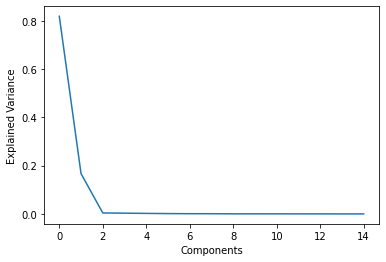

In [ ]:
df=pd.DataFrame(main_df.loc[:,main_df.columns!='track_id'])
df2=df
pca = PCA(n_components=len(df2.columns))
pca.fit(df2)
print(pca.components_)
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df2.columns))],
index=df.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [ ]:
df3=pd.DataFrame()
df3['genre']=main_df['genre']
df3['key']=main_df['key']
df3
df2=df3
df2

,genre,key
0,15,4
1,15,9
2,15,3
3,15,4
4,15,8
...,...,...
232716,24,1
232717,24,5
232719,24,1
232721,24,7


In [ ]:
#Initialising the parameters for K-means clustering
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

In [ ]:
#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df2)
    sse.append(kmeans.inertia_)

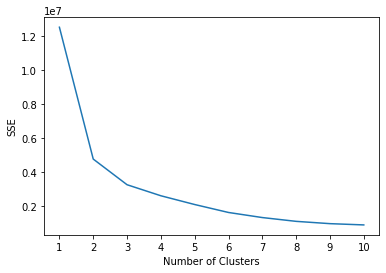

In [ ]:
#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
#There a bend at k=6, hence, for this dataset, we take k=6
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(df2)

#view cluster assignments for each observation
kmeans.labels_

array([4, 3, 4, ..., 0, 1, 1], dtype=int32)

In [ ]:
label = kmeans.fit_predict(df2)
main_df['cluster']=label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
main_df

,genre,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,cluster
0,15,0BRjO6ga9RKCKjfDqeFgWV,0.00,0.613454,0.356292,0.015167,0.910909,0.000000,4,0.339614,0.900856,0,0.032070,0.642704,3,0.814,4
1,15,0BjC1NfoEOOusryehmNudP,0.01,0.246988,0.571934,0.022029,0.737732,0.000000,9,0.142710,0.834469,1,0.068374,0.675801,3,0.816,3
2,15,0CoSDzoNIKCRs124s9uTVy,0.03,0.955823,0.650252,0.027969,0.131113,0.000000,3,0.094241,0.686429,1,0.014818,0.325182,4,0.368,4
3,15,0Gc6TVm52BwZD07Ki6tIvf,0.00,0.705823,0.196438,0.024747,0.326313,0.000000,4,0.089697,0.716695,0,0.018311,0.665238,3,0.227,4
4,15,0IuslXpMROHdEPvSl1fTQK,0.04,0.953815,0.294067,0.012142,0.225209,0.123123,8,0.194208,0.557054,0,0.024767,0.518516,3,0.390,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232716,24,1U0OMWvR89Cm20vCNar50f,0.39,0.231928,0.728570,0.037432,0.701696,0.000000,1,0.195218,0.856070,1,0.082345,0.327549,3,0.770,0
232717,24,2gGqKJWfWbToha2YmDxnnj,0.43,0.104418,0.799378,0.033550,0.516507,0.000485,5,0.096261,0.772993,0,0.201948,0.683626,3,0.482,0
232719,24,2iZf3EUedz9MPqbAvXdpdA,0.32,0.568273,0.392769,0.023346,0.337324,0.000000,1,0.268931,0.700432,1,0.022650,0.233592,3,0.497,0
232721,24,1qWZdkBl4UVPj9lK6HuuFM,0.38,0.033032,0.781139,0.048227,0.683677,0.000881,7,0.229550,0.809825,1,0.012172,0.392666,3,0.969,1


In [ ]:
'''from sklearn.metrics import silhouette_score
for i in [2,3,4,5]:
  km=KMeans(n_clusters=i,random_state=42).fit(df2)
  labels=km.labels_
  print(silhouette_score(df2,labels,metric='manhattan'))'''

"from sklearn.metrics import silhouette_score\nfor i in [2,3,4,5]:\n  km=KMeans(n_clusters=i,random_state=42).fit(df2)\n  labels=km.labels_\n  print(silhouette_score(df2,labels,metric='manhattan'))"

In [ ]:
label0=df2[label==0]
print(label0)

        genre  key
135        18    5
136        18    3
138        18    2
139        18    2
140        18    2
...       ...  ...
232713     24    4
232714     24    4
232716     24    1
232717     24    5
232719     24    1

[31742 rows x 2 columns]


In [ ]:
label0=df2[label==1]
cols = label0.columns
print(label0[cols[0]])
print(label0[cols[1]])
main_df['cluster'].value_counts()

86954     19
86959     19
86963     19
86969     19
86973     19
          ..
232700    24
232704    24
232708    24
232721    24
232724    24
Name: genre, Length: 21004, dtype: int64
86954     11
86959     11
86963      9
86969      6
86973      8
          ..
232700     9
232704    11
232708    10
232721     7
232724    11
Name: key, Length: 21004, dtype: int64


4    35252
2    32956
0    31742
5    29527
3    26293
1    21004
Name: cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


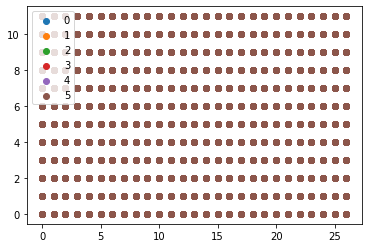

In [ ]:
u_labels = np.unique(label)
for i in u_labels:
  labeli=df2[label==i]
  cols=labeli.columns
  plt.scatter(df2['genre'], df2['key'],label=i)
plt.legend()
plt.show()

In [ ]:
from pyparsing.helpers import string
from numpy.linalg import norm
n=input("Enter ID of the song")
#A=np.array([main_df[str(main_df['track_id'])=='n']])
A=str([main_df[main_df.apply(lambda row: row.astype(str).str.contains(n).any(), axis=1)]])
print(A)

Enter ID of the song2ziWXUmQLrXTiYjCg2fZ2t
[       genre                track_id  popularity  acousticness  danceability  \
46921      3  2ziWXUmQLrXTiYjCg2fZ2t        0.44      0.904618      0.493617   

       duration_ms    energy  instrumentalness  key  liveness  loudness  mode  \
46921     0.027372  0.419408               0.0    5  0.085658  0.786018     0   

       speechiness     tempo  time_signature  valence  cluster  
46921      0.13315  0.252941               3    0.813        2  ]


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176774 entries, 0 to 232724
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             176774 non-null  int64  
 1   track_id          176774 non-null  object 
 2   popularity        176774 non-null  float64
 3   acousticness      176774 non-null  float64
 4   danceability      176774 non-null  float64
 5   duration_ms       176774 non-null  float64
 6   energy            176774 non-null  float64
 7   instrumentalness  176774 non-null  float64
 8   key               176774 non-null  int64  
 9   liveness          176774 non-null  float64
 10  loudness          176774 non-null  float64
 11  mode              176774 non-null  int64  
 12  speechiness       176774 non-null  float64
 13  tempo             176774 non-null  float64
 14  time_signature    176774 non-null  int64  
 15  valence           176774 non-null  float64
 16  cluster           17

In [ ]:
A.split(' ')
print(A[15])
final_df=main_df['cluster'].apply(lambda row:main_df['cluster']==A[15])
print(final_df)